<a href="https://colab.research.google.com/github/Unoaccaso/ML_final_project/blob/master/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf * # warning
!wget https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1 -O archive.zip
!unzip archive.zip
!7z x beta-beta-decay-identification/data_train.csv.zip -so > data_train.csv
!7z x beta-beta-decay-identification/labels_train.csv.zip -so > labels_train.csv
!rm -rf __MACOSX beta-beta-decay-identification archive.zip

--2020-06-11 17:08:24--  https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip [following]
--2020-06-11 17:08:24--  https://www.dropbox.com/s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfba80e92c5c54cd9c8e0304870.dl.dropboxusercontent.com/cd/0/get/A5eYquMCPs_NuGkjW1Eq328Bn5IMCgKeYVy69npH8y7pHQnmvLUQU5O1rSoPugbeJ8UmaKFwFjyGTychs8V5B07oQ9yWeReYSKeepGShtVDD7D2jBKSbXIlhFkZcLZRAsRc/file?dl=1# [following]
--2020-06-11 17:08:25--  https://ucfba80e92c5c54cd9c8e0304870.dl.dropboxusercontent.com/cd/0/get/A5eYquMCPs_NuGkjW1Eq328Bn5IMCgKeYVy69npH8y7

In [0]:
import numpy as np
import cupy as cp
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

In [0]:
data_train = pd.read_csv('data_train.csv')
labels_train = pd.read_csv('labels_train.csv')

In [0]:
def create_images(data, n_theta_bins=10, n_phi_bins=20, n_time_bins=6):
    labels = []
    images = []
    event_indexes = {}
    event_ids = np.unique(data['EventID'].values)
    
    # collect event indexes
    data_event_ids = data['EventID'].values
    for i in range(len(data)):
        i_event = data_event_ids[i]
        if i_event in event_indexes:
            event_indexes[i_event].append(i)
        else:
            event_indexes[i_event] = [i]
            
    # create images
    for i, i_event in enumerate(tqdm(event_ids)):
        event = data.iloc[event_indexes[i_event]]
        X = event[['Theta', 'Phi', 'Time']].values
        one_image, edges = np.histogramdd(X, density=False,
                                          bins=(n_theta_bins, n_phi_bins, n_time_bins))
        images.append(one_image)
        label = labels_train[labels_train["EventID"]==i_event]["Label"].values[0]
        labels.append(label)
    return (np.array(images), np.array(labels))

In [5]:
images, labels = create_images(data_train,
                               n_theta_bins=10, 
                               n_phi_bins=20, 
                               n_time_bins=6)

100%|██████████| 80000/80000 [02:40<00:00, 497.78it/s]


In [6]:
print(images.shape)
print(labels.shape)

(80000, 10, 20, 6)
(80000,)


# Data manipulation

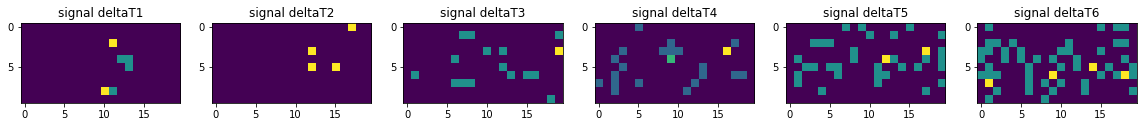

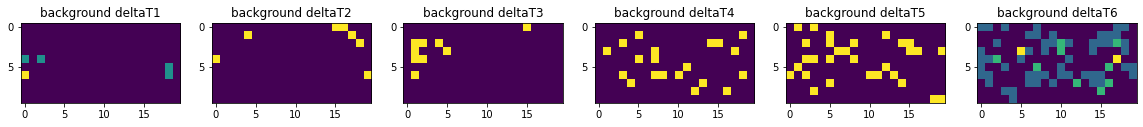

In [7]:
signal = images[labels == 1]
background = images[labels == 0]

sig = np.random.randint(0, signal.shape[0])
back = np.random.randint(0, background.shape[0])

plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(signal[sig][:, :, i])
  plt.title(f'signal deltaT{i+1}')
plt.show()
plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(background[back][:, :, i])
  plt.title(f'background deltaT{i+1}')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.029s...
[t-SNE] Computed neighbors for 500 samples in 0.642s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.043590
[t-SNE] KL divergence after 250 iterations with early exaggeration: 142.426071
[t-SNE] KL divergence after 700 iterations: 2.609694


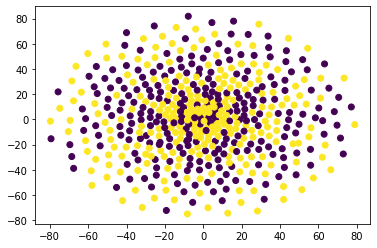

In [8]:
# Preparing TSNE
data = images.reshape((images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))
index = np.random.randint(0, data.shape[0], 500)
data = data[index]

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=700)
axs = tsne.fit_transform(data)


plt.scatter(x = axs[:, 0], y = axs[:, 1], c=labels[index])

# NN training

In [0]:
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(images, labels, test_size=0.2)

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [42]:
print(X_train.shape)
print(Y_train.shape)

(64000, 10, 20, 6)
(64000,)


In [43]:
IMG_SHAPE = (10, 20, 6)

img_input = keras.Input(shape=IMG_SHAPE, name="D_Image_Input")
x = img_input

# primo blocco Convoluzionale
x = keras.layers.Conv2D(filters=8, kernel_size=(3, 5),name='Conv_1')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = layers.Dropout(0.11, name="DropOut_1")(x)

# secondo blocco Convoluzionale
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), name='Conv_2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = layers.Dropout(0.2, name="DropOut_2")(x)

'''# terzo blocco Convoluzionale
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), name='Conv_3')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_3')(x)
x = layers.Dropout(0.2, name="DropOut_3")(x)'''

x = keras.layers.Flatten(name='Flatten')(x)

# layer densi
x = keras.layers.Dense(32, name='Dense_1')(x)
x = layers.Dropout(0.12, name="DropOut_5")(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)

outputs = keras.layers.Dense(1, activation='sigmoid', name='Output')(x)

model = keras.Model(inputs=img_input, outputs=outputs, name='predictor')

#printout il summary del modello
model.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D_Image_Input (InputLayer)   [(None, 10, 20, 6)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 8, 16, 8)          728       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 16, 8)          32        
_________________________________________________________________
ReLU_1 (ReLU)                (None, 8, 16, 8)          0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 8, 16, 8)          0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 6, 14, 16)         1168      
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 14, 16)         64

In [44]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='cnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

LR_ST=1e-3

def lr_decay(epoch):
  start = 10
  if epoch < start:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (start - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# metto tutte le callback in una lista
callbacks = [ 
             lr_scheduler,
             model_checkpoint,
             keras.callbacks.EarlyStopping(monitor='loss', patience=5)
             ]      

model.compile(loss="binary_crossentropy", optimizer='adam', 
              metrics=["accuracy",
                       keras.metrics.AUC(name='auc')])
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=512, 
          epochs=50, shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
113/113 [==============================] - 1s 11ms/step - loss: 0.7001 - accuracy: 0.5089 - auc: 0.5105 - val_loss: 0.6923 - val_accuracy: 0.5128 - val_auc: 0.5402 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 0.6351 - accuracy: 0.6287 - auc: 0.6888 - val_loss: 1.4631 - val_accuracy: 0.5027 - val_auc: 0.7425 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - 1s 8ms/step - loss: 0.5516 - accuracy: 0.7245 - auc: 0.7936 - val_loss: 0.6772 - val_accuracy: 0.6297 - val_auc: 0.8018 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 0.5357 - accuracy: 0.7357 - auc: 0.8070 - val_loss: 0.5746 - val_accuracy: 0.7013 - val_auc: 0.8116 - lr: 0.0010
Epoch 5/50
113/113 [==============================] - 1s 8ms/step - loss: 0.5272 - accuracy: 0.7415 - auc: 0.8141 - val_loss: 0.5440 - val_accuracy: 0.7234 - val_auc: 0.8161 - lr: 0.0010
Epoch 6/50
113/113 [==============================] - 1s 8ms/ste

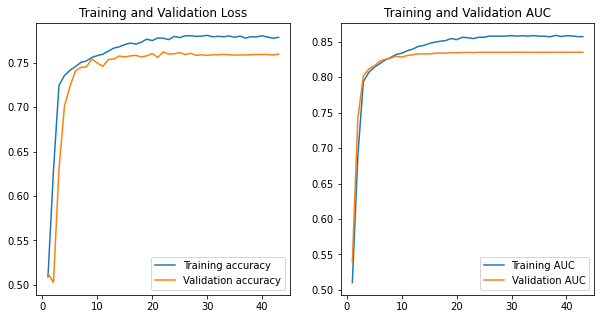

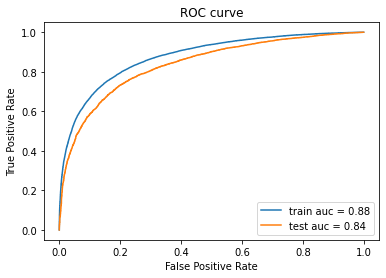

In [45]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

AUC=history.history['auc']
val_AUC=history.history['val_auc']

epochs_range = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc=4)
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, AUC, label='Training AUC')
plt.plot(epochs_range, val_AUC, label='Validation AUC')
plt.legend(loc=4)
plt.title('Training and Validation AUC')

plt.show()

# Building ROC curves

from sklearn.metrics import roc_auc_score, roc_curve

data = ((X_train, Y_train),
        (X_test, Y_test)
        )
for i, dataset in enumerate(['train', 'test']):
  pred = model.predict(data[i][0], verbose=0)
  auc = roc_auc_score(data[i][1], pred)
  fpr, tpr, thr =roc_curve(data[i][1], pred)
  plt.plot(fpr, tpr, label = f'{dataset} auc = {auc:.2f}' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

# CNN Study

['D_Image_Input', 'Conv_1', 'batch_normalization_2', 'ReLU_1', 'DropOut_1', 'Conv_2', 'batch_normalization_3', 'ReLU_2', 'DropOut_2', 'Flatten', 'Dense_1', 'DropOut_5', 'ReLU_dense_1', 'Output']


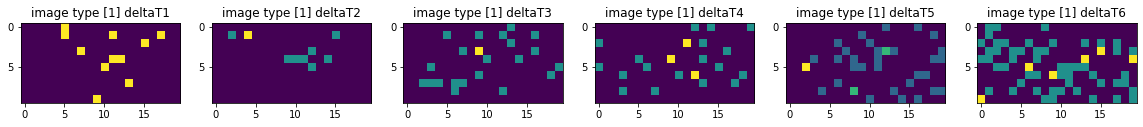

<Figure size 1440x720 with 0 Axes>

In [46]:
#salviamo i nomi di tutti i layers della rete nella lista layer_names
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
print(layer_names)

# estraiamo gli output da tutti i 20 layers della nostra rete
layer_outputs = [layer.output for layer in model.layers[:22]]

# instanziamo un semplice modello keras che prende l'immagine in input e restituisce 
# tali output (le attivazioni)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)


index = np.random.randint(0, X_test.shape[0], 1)
immagine = X_test[index]

plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(immagine[0][:, :, i])
  plt.title(f'image type {Y_test[index]} deltaT{i+1}')
plt.show()
plt.figure(figsize=(20, 10))

# e estraiamone le attivazioni
activations = activation_model.predict(immagine)

(1, 8, 16, 8)


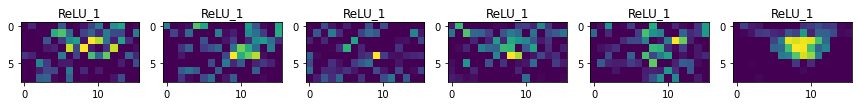

In [47]:
# grafichiamo gli output per il primo layer convoluzionale (è il layer numero 
# 3 (dopo ReLU) nel nostro modello)

layer = 3
first_layer_activation = activations[layer]
print(first_layer_activation.shape)

k = 0
plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 8, k + 1)
  plt.imshow(first_layer_activation[0, :, :, k], cmap='viridis') 
  plt.title(layer_names[layer])
  k = k + 1

Filtri layer convoluzionale:  Conv_1


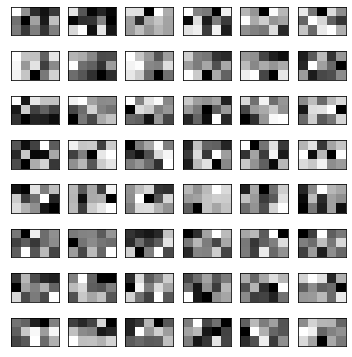

Filtri layer convoluzionale:  Conv_2


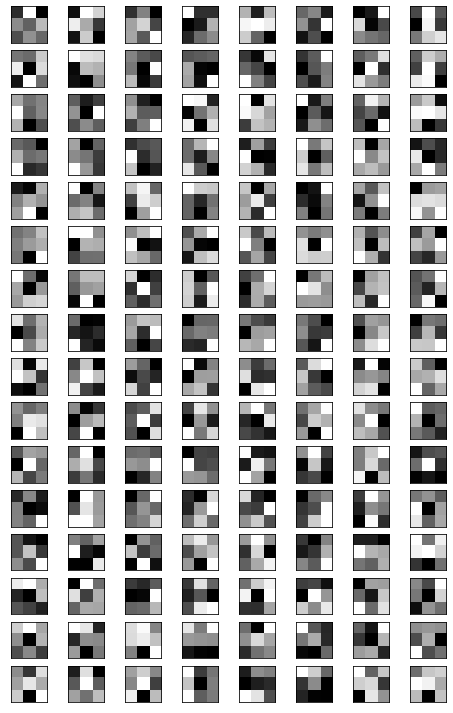

In [48]:
for layerc in ['Conv_1', 'Conv_2']:
    print('Filtri layer convoluzionale: ', layerc)
    # pesi del layer selezionato:
    filters, biases = model.get_layer(layerc).get_weights()
    # numero dei filtri 
    n_filters = filters.shape[3]
    # numero canali 
    n_channels = filters.shape[2]
    # normalizzazione in [0,1] per rendere più chiaro il plot
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    k = 1
    plt.figure(figsize=(n_channels, n_filters*0.8), frameon=False)
    for i in range(n_filters):
        f = filters[:, :, :, i]
        # plot del filtro per ogni canale RGB
        for j in range(n_channels):
            ax = plt.subplot(n_filters, n_channels, k)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap='gray')
            k = k + 1

    plt.show()

# Test con XGBoost

In [52]:
data = images.reshape((images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))

print(data.shape)

pca = PCA(n_components=100)
data = pca.fit_transform(data)

print(data.shape)

(data_X_train, data_X_test, data_Y_train, data_Y_test) = train_test_split(data, labels, test_size=0.2)

print(data_X_train.shape)
print(data_Y_train.shape)
print(data_X_test.shape)
print(data_Y_test.shape)


(80000, 1200)
(80000, 100)
(64000, 100)
(64000,)
(16000, 100)
(16000,)


In [53]:
# === XGBoost
import xgboost as xgb
from sklearn import metrics as sk

t0 = time()
xgb_mod = xgb.XGBClassifier().fit(data_X_train, data_Y_train, verbose=1)
t1 = time()

print(f'tempo impiegato: {t1-t0:.2f}')

tempo impiegato: 38.58



Accuracy del modello sul training set: 0.741
Accuracy del modello sul test set: 0.739

Accuracy del modello sul training set: 0.741
Accuracy del modello sul test set: 0.740


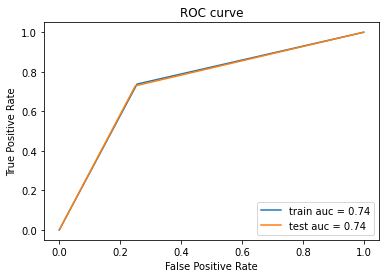

In [58]:
test_predict = xgb_mod.predict(data_X_test)
train_predict = xgb_mod.predict(data_X_train)

data = ((data_Y_train, train_predict),
        (data_Y_test, test_predict))

train_acc = sk.accuracy_score(train_predict, data_Y_train)
test_acc = sk.accuracy_score(test_predict, data_Y_test)
print(f'\nAccuracy del modello sul training set: {train_acc:.3f}')
print(f'Accuracy del modello sul test set: {test_acc:.3f}')

train_auc = sk.roc_auc_score(data_Y_train, train_predict)
test_auc = sk.roc_auc_score(data_Y_test, test_predict)
print(f'\nAccuracy del modello sul training set: {train_auc:.3f}')
print(f'Accuracy del modello sul test set: {test_auc:.3f}')

for i, dataset in enumerate(['train', 'test']):
  pred = data[i][1]
  auc = roc_auc_score(data[i][0], pred)
  fpr, tpr, thr =roc_curve(data[i][0], pred)
  plt.plot(fpr, tpr, label = f'{dataset} auc = {auc:.2f}' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

# Random Forest

In [0]:
# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier

n_estimator_range=np.arange(min_estimators, max_estimators, 10) #testiamo 10 valori per il primo iperparametro

leaf_size_list=[2, 3, 4, 5] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))
RFC_train_AUC_accuracy=np.zeros((n,m))
RFC_test_AUC_accuracy=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    )
    for j, n_estimator in enumerate(n_estimator_range):
        
        print('\nn_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(data_X_train, data_Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(data_X_train,data_Y_train)
        RFC_train_AUC_accuracy[i,j]=sk.roc_auc_score(data_Y_train, myRF_clf.predict(data_X_train))
        RFC_test_accuracy[i,j]=myRF_clf.score(data_X_test,data_Y_test)
        RFC_test_AUC_accuracy[i,j]=sk.roc_auc_score(data_Y_test, myRF_clf.predict(data_X_test))
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_train_AUC_accuracy[i,j], RFC_test_accuracy[i,j], RFC_test_AUC_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "train AUC", "test score", "test AUC" ))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))


n_estimators: 10, leaf_size: 2
time (s)       train score    train AUC      test score     test AUC       
12.6886        0.9904         0.9904         0.7069         0.7076         

n_estimators: 20, leaf_size: 2
time (s)       train score    train AUC      test score     test AUC       
12.5630        0.9986         0.9986         0.7328         0.7331         

n_estimators: 30, leaf_size: 2
time (s)       train score    train AUC      test score     test AUC       
12.7928        0.9998         0.9998         0.7473         0.7476         

n_estimators: 40, leaf_size: 2
time (s)       train score    train AUC      test score     test AUC       
13.5048        0.9999         0.9999         0.7566         0.7569         

n_estimators: 50, leaf_size: 2
time (s)       train score    train AUC      test score     test AUC       
13.3191        1.0000         1.0000         0.7606         0.7608         

n_estimators: 60, leaf_size: 2
time (s)       train score    train AUC      tes